In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
#First Dataframe ##########################
url_1 = "http://www.jmulti.de/download/datasets/e2.dat"
df_1  = pd.read_csv(url_1).iloc[:,:1]
df_1 = df_1.iloc[:,0].str.split()[7:]
df_fix = pd.DataFrame(columns = ["US Fixed Investment (1947-1974)", "Quaterly Changes"])
df_fix["US Fixed Investment (1947-1974)"] = [float(element[0]) for element in df_1]
df_fix["Quaterly Changes"] = [float(element[1]) for element in df_1]
#Second Dataframe ##########################
url_2 = "http://www.jmulti.de/download/datasets/e3.dat"
df_2  = pd.read_csv(url_1).iloc[:,:1]
df_2 = df_2.iloc[:,0].str.split()[8:]
df_yield = pd.DataFrame()
df_yield["Quaterly German Nominal GDP"] = [float(element[0]) for element in df_2]
#Third Dataframe ##########################
url_3 = "http://www.jmulti.de/download/datasets/NP_xetradax_returns100.dat"
df_3  = pd.read_csv(url_3, on_bad_lines='skip').iloc[:,:1]
df_3 = df_3.iloc[:,0].str.split()[7:]
df_stock = pd.DataFrame()
df_stock["DAX Daily Returns"] = [float(element[0]) for element in df_3]
#Fourth Dataframe: Disposable income ##########################
url_4 = "http://www.jmulti.de/download/datasets/e4.dat"
df_4  = pd.read_csv(url_4, on_bad_lines='skip').iloc[:,:1]
df_4 = df_4.iloc[:,0].str.split()[7:]
df_disposable = pd.DataFrame()
df_disposable["Quaterly Per Capital Disposible Income"] = [float(element[0]) for element in df_4]

### Introduction

We will briefly discuss __autoregressive processes (AR)__. In addition we will consider __moving averages (MA)__ and __mixed autorregressive moving average (ARMA)__ models. Furthermore, we will consider __autoregressive integrated moving average (ARIMA) processes and seasonal variants__.

To simplify it is useful to use the lag operator ($L$).

### 1. Autoregressive Processes

An AR process of order p ($AR(p)$) may be written as:

$$y_t = \alpha_1y_{t-1} + \ldots + \alpha_py_{t-p} + u_t$$

where $u_t$ is an unobservable zero mean withe noise process with time invariant variance $\mathbb{E}(u_t^2) = \sigma_u^2$ and the $\alpha_i$ are fixed coefficients.

In terms of the lag operator ($Ly_t = y_{t-1}$):

$$\left(1 - \alpha_1L - \ldots - \alpha_pL^p\right)y_t = u_t \space \text{ or } \space \alpha(L)y_t = u_t$$

In the case the process it is stable, it can be represented as the __weighted sum of past errors__. 

$$y_t = \alpha{L}^{-1}u_t =	\phi(L)u_t = u_t + \sum_{j=1}^{+\infty}\phi_ju_{t-j}$$


#### Statistics of AR processes

- Mean: 0
- Variance: $\sigma_y^2 = \gamma_0 = \sigma_u^2\sum_{j = 0}^{j = \infty}\phi_j^2$
- Autocovariance: $\gamma_h = \sigma_u^2\sum_{j = 0}^{j = \infty}\phi_j \times \phi_{j+h} $
- Spectral Density: $f_y(\lambda) = (2\pi)^{-1}\sigma_u^2\lvert\alpha(e^{i\lambda})\rvert^{-2}$

In [3]:
def ar1_process(alpha, sigma, n):
  # Initialize the time series with a random normal value
  X = [np.random.normal(0, sigma)]
  
  # Generate the remaining n-1 values of the time series
  for t in range(1, n):
    X.append(alpha * X[t-1] + np.random.normal(0, sigma))
    
  return np.array(X)

In [16]:
def spectral_density(time_series, lambda_, truncation_period):
    weights = [1 - j/truncation_period for j in range(truncation_period)]
    autocorrelations = []
    for j in range(truncation_period):
        autocorrelations.append(time_series.autocorr(lag=j))
    output = 1/(2*math.pi)*(weights[0]*autocorrelations[0] + 2*sum([weights[j]*autocorrelations[j]*math.cos(lambda_*j) for j in range(1, truncation_period)]))
    return output

<AxesSubplot:>

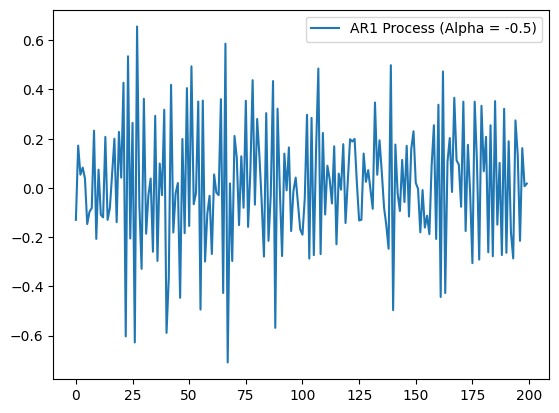

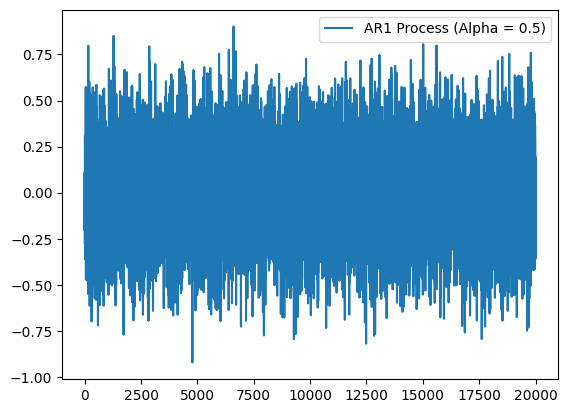

In [30]:
# Generate a realization of an AR(1) process with alpha = 0.8 and sigma = 1
df = pd.DataFrame(ar1_process(-0.5, 0.2, 200), columns = ['AR1 Process (Alpha = -0.5)'])
df_pos = pd.DataFrame(ar1_process(0.5, 0.2, 20000), columns = ['AR1 Process (Alpha = 0.5)'])
df.plot()
df_pos.plot()

[]

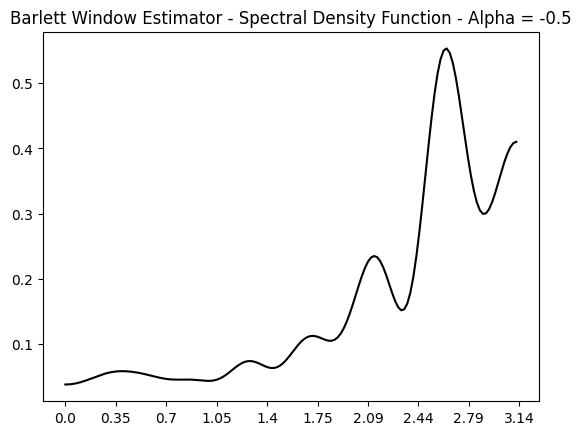

In [31]:
spectre = [spectral_density(df.squeeze(), element, 20) for element in np.linspace(0, math.pi, num = 150)]
spectre_pos = [spectral_density(df_pos.squeeze(), element, 20) for element in np.linspace(0, math.pi, num = 150)]
plt.plot(spectre, color='black')
xi = np.linspace(0, math.pi, num = 10)
xi = [round(element, 2) for element in xi]
plt.xticks(np.linspace(0, 150, num = 10), xi)
plt.title("Barlett Window Estimator - Spectral Density Function - Alpha = -0.5")
plt.plot()


[]

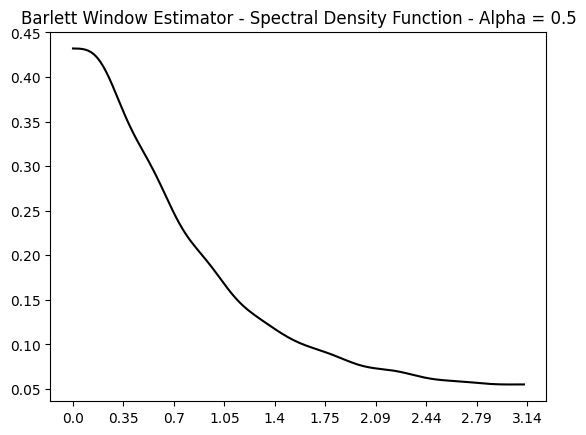

In [32]:
spectre_pos = [spectral_density(df_pos.squeeze(), element, 20) for element in np.linspace(0, math.pi, num = 150)]
plt.plot(spectre_pos, color='black')
xi = np.linspace(0, math.pi, num = 10)
xi = [round(element, 2) for element in xi]
plt.xticks(np.linspace(0, 150, num = 10), xi)
plt.title("Barlett Window Estimator - Spectral Density Function - Alpha = 0.5")
plt.plot()

- Cuando el alpha es positivo, los elementos consecutivos evolucionan hacia el mismo sentido, pequenas frecuencias van a contribuir a la variabilidad total de la serie de forma mas determinante. 

- Sin embargo, si la autocovarianza es negativa, un punto por encima de la media vendra seguido de un punto por debajo de esta. Por lo tanto en frecuencias pequenas no hay casi varianza. La variabilidad de esta serie esta en frecuencias mayores.

#### AR(p) processes and unit root

If, for an $AR(p)$ process $\alpha(z)$ has a root for $z = 1$ the operator in the AR process can be factored as: 

$$\alpha(L) = (1 - \alpha_1 L - \ldots - \alpha^{p-1}L^{p-1})(1-L)$$

If we replace $1 - L$ by $\Delta$:

$$u_t = (1 - \alpha_1^{*} L - \ldots - \alpha_{p-1}^{*}L^{p-1})\Delta y_t$$

Which is an $AR(p_1)$ model for the first difference of $y_t$. If this models has all of his roots outside the complex unit circle, $\Delta y_t$ is stationary. And $y_t$ is $I(1)$. Otherwise, if it has another unit root, we repeat the process. 



### 2. Finite-Order Moving Average Processes

The process $y_t$ can be represented as: 
$$y_t = u_t + m_1u_{t-1} + \ldots + m_qu_{t-q}$$

Where $u_t$ is again a zero mean white noise, the process is called __moving average of order q (MA(q))__.

Can be written more compactly as: 
$$y_t = (1 + m_1L + \ldots + m_qL^{q})u_t \space \text{or }\space y_t = m(L)u_t$$

Uniqueness of the representation is guaranteed if the characteristic equation has no unit roots, then the process is called __invertible__. In that case it has an infinite order AR representation: 
$$m(L)^{-1}y_t = \alpha(L)y_t = y_t - \sum_{j=1}^{\infty}\alpha_jy_{t-j} = u_t $$

*Exercise: Try to look for conditions on $m_1$ for MA(1) process being invertible. (pg.25)*

#### Statistics of MA processes